In [1]:
# from suite2p.extraction import dcnv
import nbimporter
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from PIL import ImageEnhance

#....................................Functions for processing data. 
from Functions import flatten
from Functions import _get_stim_list
from Functions import _cells_only
from Functions import _load_data
from Functions import _data_structure
from Functions import _norm_whole_trace
from Functions import _norm_by_stim

# from Functions import _suite2p_filter
from Functions import _rolling_filter
from Functions import _savgol_filter
from Functions import _reshape_df

from Functions import findspks
from Functions import find_peaks 
from Functions import _baseline_stats
from Functions import _pickle_waves

## Acquisition Parameters and Experiment Info

In [2]:
#Define acquisition parameters
tau = .7                       # timescale of indicator
framerate = 30                 # CONSTANT fo frames per second. Based on period of 33.731ms. Do not change
frame_average = 1              # Rasters per frame. Adjust if you average frames *during acquisition*
fs = framerate/frame_average   # sampling rate in Hz
neucoeff = 0.7                 # neuropil coefficient (default is 0.7)
threshold = 3                  # stdDev above baseline to find event

# Sample metadata
mouseID = 'PVT6-144, 1271116-20' #Cage ID, CC#-(Toe ID)
mouse_geno = 'T6+, PV+'
group = 'WT'
mouseDOB = '2020/11/20'          # YYYY/MM/DD
mouseAGE = 145                   #in DAYS

GCaMP_virus = 'IC, CaMKII'       #RO or IC. 
expression_time = 100             #in DAYS

wavelength = 965
objective = '16x'
sliceID = 'DMS'

#set filename for output
experiment_date = '2021-04-14'
experiment = 's2_ACSF_IEM_PICRO'

#Parameters for analysis
stimulations = [900]
extra_pulses = ['x2']                      #write in list as ['x2', 'x3'], etc. Set to 0 if none. 
drug_treatments = ['ACSF2','IEM', 'PICRO']                #List drug treatments IN ORDER. ACSF is assumed for initial recordings. 

repetition   = 5                           # number of times each stimulus is repeated
framenum     = 90                          # number of frames for each stimulation epoch
stimtime     = 1000                        # time of stimulation after start of recording (ms)

#Constants for Smoothing Data
savgol_frames = 7
savgol_order = 3


#Values for max/min suite2p filter. 
baseline = 'maximin'     # take the running max of the running min after smoothing with gaussian
sig_baseline = 2        # in bins, standard deviation of gaussian with which to smooth (default 10)
win_baseline = 10        # in seconds, window in which to compute max/min filters (default 50)

ops = {'tau': tau, 'fs': fs, 'neucoeff': neucoeff,
       'baseline': baseline, 'sig_baseline': sig_baseline, 'win_baseline': win_baseline}



## Load Data from folder

In [3]:
#..............Previous iterations of the pipeline had been subtracting the flourescence of the neuropil (as calculated in suite2p) from the F signal before any processing. 
#..............As of 2021-08-24, removed this. Noticed it was yielding very low/negative values for some baselines and very high values for normalized dF/F (when F0 was <1 or <0, for example)
#..............To get the neuropil subtracted data, set 'subtract = True'
data, Fneu, iscell, stat, ops_orig, im, Fred, fchan = _load_data(subtract = False)

filelist = ops_orig['filelist']
print("Total Files: " + str(len(filelist)) + '\nOriginal Tiff Files in order')
for i in range(len(filelist)):
    print(filelist[i])

Returns values: 'data', 'Fneu', 'iscell', 'stat', 'Fc', 'ops_orig', 'im'
Data Shape: (181, 3600)
Total Files: 4
Original Tiff Files in order
Z:/Data/BrandonTshared/_Data/__Paradoxical FSI--Modeling Collab/Slice Imaging/DMSO Controls_2021-Apr/4-14_Flat/s2\(t)0414_965_DMS(L)#2_ACSF2-005_FLAT.tif
Z:/Data/BrandonTshared/_Data/__Paradoxical FSI--Modeling Collab/Slice Imaging/DMSO Controls_2021-Apr/4-14_Flat/s2\(t)0414_965_DMS(L)#2_ACSF-004_FLAT.tif
Z:/Data/BrandonTshared/_Data/__Paradoxical FSI--Modeling Collab/Slice Imaging/DMSO Controls_2021-Apr/4-14_Flat/s2\(t)0414_965_DMS(L)#2_IEM-006_FLAT.tif
Z:/Data/BrandonTshared/_Data/__Paradoxical FSI--Modeling Collab/Slice Imaging/DMSO Controls_2021-Apr/4-14_Flat/s2\(t)0414_965_DMS(L)#2_PICRO-007_FLAT.tif


## List of stimulation values

In [4]:
#NOTE: This works if multi-pulse stimulation immediately follow single stim (i.e. 100, 100x2, 100x3). Else, if they repeat as such: [100, 100, 100, 100x2, 100x2, 100x2], 
# or it's a completely different order, you'll have to manually write it in manually for the 'stimulations' variable or change it later. 
##################################################################################################################################################################################################################
print(stimulations)
stimulations = _get_stim_list(stimulations, extra_pulses, drug_treatments)

##########################
# Manually written stims
##########################

# stimulations = ['900-pre','900-pre','900-pre','900-pre','900-pre',
#                'LED', 'LED-pre', 'LED-post', '900-inter',
#                'LED', 'LED-pre', 'LED-post', '900-inter',
#                'LED', 'LED-pre', 'LED-post', '900-inter',
#                'LED', 'LED-pre', 'LED-post', '900-inter',
#                'LED', 'LED-pre', 'LED-post', '900-inter',
#                '900-post', '900-post', '900-post', '900-post', '900-post', 
#                '900x3']

print(stimulations)

print(len(stimulations))

[900]
Total Stims: 8 /nStim Vals:/n {stimulations}
[900, '900x2', '900-ACSF2', '900x2-ACSF2', '900-IEM', '900x2-IEM', '900-PICRO', '900x2-PICRO']
8


## Limit data to 'iscell' ROIs

In [5]:
d_cells, d_cells_shape, indices = _cells_only(data, iscell)

Original Shape: (181, 3600)
New Shape: (113, 3600)


## Frame data structure

In [6]:
cellnum, stim_intensity, stim_num, baselineframenum = _data_structure(indices, stimulations, repetition, fs, stimtime=stimtime, chrimson=False)


[900, '900x2', '900-ACSF2', '900x2-ACSF2', '900-IEM', '900x2-IEM', '900-PICRO', '900x2-PICRO']


## Normalize Traces

In [7]:
row_size = len(indices)*len(stimulations)*repetition
print(row_size)
print(len(cellnum))
col_size = framenum

savgol_frames = 7 #........................................................................Window for Savgol Polynomial Fit
savgol_order = 3 #.........................................................................Order of Savgol Polynomial (2 or 3)
roll_window = 7 #..........................................................................Window for rolling mean calculations. 
roll_period = 1 #..........................................................................Min number of values required for average calculation. 

########################################
########## Smooth the data #############
########################################

w_norm = _norm_whole_trace(d_cells) #.......................................................whole trace normalized by trace mean
e_norm = _norm_by_stim(d_cells, baselineframenum, row_size, col_size) #.....................each epoch normalzized within itself
e_norm_originalshape = np.reshape(e_norm, w_norm.shape) #...................................whole trace normalized reshaped to match epoch format
raw_reshape = np.reshape(d_cells, e_norm.shape) #...........................................Raw values reshaped to match epoch format

# sp = _suite2p_filter(e_norm, ops, adjust=False) #............NOT USED.......................suite2p Min/Max filter of epoch format
roll_e = _rolling_filter(e_norm, roll_window, roll_period) #....................................................Rolling mean window filter of each epoch
sav_e = _savgol_filter(e_norm, savgol_frames, savgol_order) #...............................Savgol filter of each epoch

roll_raw = _rolling_filter(raw_reshape, roll_window, roll_period) #.............................................Rolling mean window filter of each epoch; Raw data, for QC. 
sav_raw = _savgol_filter(raw_reshape, savgol_frames, savgol_order) #........................Savgol filter of each epoch; Raw data, for QC. 

sigma = 3
baselineframenum = int(np.floor((stimtime-100)/1000*fs))
print(f"Baseline Frames: {baselineframenum}")

4520
4520
Returns reshaped dataframe normalized within each stim period. Must specify 'data', 'baselineframenum', 'rows', and 'columns'
Returned Value Shape: (4520, 90)
Returned Value Shape: (4520, 90)
Baseline Frames: 27


## Smooth Data and Find Peaks

In [8]:
rolling = True #............................................................................If 'True', uses rolling mean averages to calculate all values. 

#.............In development, File '2021-05-20_s1_ChrimsonR_Sequence' yielding the following peaks. 
#.............Peaks from rolling == 1075
#.............Peaks from savgol  == 1161


if rolling: 
    
    spk_frame, spk_time, spk_binary, Fmean_arr, devF_arr = findspks(roll_e, sigma, cellnum, baselineframenum, fs, int(roll_window/2))
    Fpeak, dFoverF, auc_calc = find_peaks(roll_e, baselineframenum, spk_frame, spk_time, spk_binary, Fmean_arr, fs)

    spk_frame2, spk_time2, spk_binary2, Fmean_arr2, devF_arr2 = findspks(roll_raw, sigma, cellnum, baselineframenum, fs, int(roll_window/2))
    Fpeak2, dFoverF2, auc_calc2 = find_peaks(roll_raw, baselineframenum, spk_frame2, spk_time2, spk_binary2, Fmean_arr2, fs)
    waves = roll_e
else: 
    
    #.................................................................Find spikes, Fmean, dFoverF using baseline normalized traces passed through savgol filter. 
    spk_frame, spk_time, spk_binary, Fmean_arr, devF_arr = findspks(sav_e, sigma, cellnum, baselineframenum, fs, savgol_frames)
    Fpeak, dFoverF, auc_calc = find_peaks(sav_e, baselineframenum, spk_frame, spk_time, spk_binary, Fmean_arr, fs)
    #.................................................................Find spikes, Fmean, dFoverF using 'raw' traces passed through savgol filter    
    spk_frame2, spk_time2, spk_binary2, Fmean_arr2, devF_arr2 = findspks(sav_raw, sigma, cellnum, baselineframenum, fs, savgol_frames)
    Fpeak2, dFoverF2, auc_calc2 = find_peaks(sav_raw, baselineframenum, spk_frame2, spk_time2, spk_binary2, Fmean_arr2, fs)
    waves = sav_e
    
#..................................................................Q.C. -- Spike Count, Fpeak values, and dFoverF
print(f"Spikes from normalized traces: {len(spk_binary[spk_binary == 1])}")
print(f"Spikes from raw traces: {len(spk_binary2[spk_binary2 == 1])}")

Spike array shape: (4520,)
FPeak array shape: (4520,)
Spike array shape: (4520,)
FPeak array shape: (4520,)
Spikes from normalized traces: 3355
Spikes from raw traces: 3355


## Save Waveforms for Reference

In [9]:
waves_df = _pickle_waves(waves, iscell, stimulations, repetition, experiment, experiment_date)
waves_df.head(2)

,ROI#,Stim1,Stim2,Stim3,Stim4,Stim5,Stim6,Stim7,Stim8,Stim9,...,Stim31,Stim32,Stim33,Stim34,Stim35,Stim36,Stim37,Stim38,Stim39,Stim40
0,2021-04-14_s2_ACSF_IEM_PICRO-Cell_Num-4,"[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",...,"[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
1,2021-04-14_s2_ACSF_IEM_PICRO-Cell_Num-5,"[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",...,"[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...","[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."


## Red Channel

#### Extract cell location & Red Channel Fluorescence. Plot for QC. 

In [10]:
from Functions import _assign_id
from Functions import _cell_location

fredmean, frednorm, fmean_shaped, fnorm_shaped, d1, d1_strict, d1_d2, cutoff, interval_pos, interval_neg, raw_cutoff, raw_interval_pos, raw_interval_neg = _assign_id(Fred, iscell, stimulations, repetition)
xcoords_reshaped, ycoords_reshaped, im, xcoords, ycoords = _cell_location(stat, indices, stimulations, repetition, im)


F-RED array shape:  (181, 3600)
F-RED mean array shape:  (181,)
[251, 268, 39, 83, 319, 318, 259, 332, 235, 362, 189, 270, 287, 318, 231, 188, 356, 270, 185, 205, 235, 173, 299, 306, 250, 289, 146, 296, 198, 191, 364, 138, 330, 153, 241, 83, 128, 367, 176, 384, 249, 359, 225, 224, 183, 202, 263, 322, 231, 172, 345, 328, 251, 305, 104, 219, 243, 250, 297, 149, 216, 311, 143, 107, 225, 286, 206, 277, 320, 257, 229, 266, 171, 146, 153, 172, 252, 116, 142, 189, 155, 111, 197, 189, 295, 108, 157, 338, 239, 250, 180, 143, 250, 213, 187, 321, 233, 124, 197, 218, 240, 138, 281, 160, 137, 254, 312, 204, 249, 316, 230, 200, 198]
[71, 75, 90, 93, 107, 129, 131, 139, 140, 140, 149, 151, 153, 154, 154, 170, 174, 183, 187, 190, 195, 195, 196, 202, 205, 207, 211, 211, 212, 214, 217, 221, 224, 227, 227, 234, 234, 235, 235, 237, 239, 239, 244, 253, 254, 255, 256, 255, 262, 265, 265, 270, 270, 273, 274, 276, 277, 279, 280, 282, 282, 290, 292, 296, 298, 300, 301, 302, 305, 305, 309, 309, 309, 314, 317, 3

## Compile DataFrame

In [11]:
#Duplicate the metadata to fit into the dataframe
experiment_tag = np.repeat(str(experiment_date + '_'+ experiment),len(stimulations)*repetition*len(indices))
_date = np.repeat(experiment_date, len(stimulations)*repetition*len(indices))
_group = np.repeat(group, len(stimulations)*repetition*len(indices))

_mouseID = np.repeat(mouseID, len(stimulations)*repetition*len(indices))
_mouse_geno = np.repeat(mouse_geno, len(stimulations)*repetition*len(indices))
_mouseDOB = np.repeat(mouseDOB, len(stimulations)*repetition*len(indices))
_mouseAGE = np.repeat(mouseAGE, len(stimulations)*repetition*len(indices))
_GCaMP_virus = np.repeat(GCaMP_virus, len(stimulations)*repetition*len(indices))
_expression_time = np.repeat(expression_time, len(stimulations)*repetition*len(indices))
_wavelength = np.repeat(wavelength, len(stimulations)*repetition*len(indices))
_objective = np.repeat(objective, len(stimulations)*repetition*len(indices))
_sliceID = np.repeat(sliceID, len(stimulations)*repetition*len(indices))


d = {'cell_num': cellnum, 
     'Experiment': experiment_tag,
     'Date': _date,
     'Group': _group,
     'ID':d1, 
     'StrictID': d1_strict,
     'Red Intensity (Avg)': fmean_shaped, 
     'Red norm': fnorm_shaped,
     'x-coords': xcoords_reshaped, 
     'y-coords': ycoords_reshaped, 
     'stim_intensity': stim_intensity, 
     'stim_num': stim_num, 
     'F_mean': Fmean_arr, 
     'StdDev' : devF_arr, 
     'spike_happened': spk_binary, 
     'spike_time(ms)': spk_time, 
     'dF': Fpeak, 
     'AUC': auc_calc, 
     'dF/F(%)': dFoverF,
     'MouseID': _mouseID,
     'Genotype': _mouse_geno, 
     'DOB': _mouseDOB, 
     'Age (days)': _mouseAGE, 
     'GCaMP Virus': _GCaMP_virus, 
     'Expression Time (days)': _expression_time, 
     'Excitation Wavelength (nm)': _wavelength, 
     'Objective': _objective, 
     'Slice ID': _sliceID
    }

df = pd.DataFrame(data=d)
df.insert(6, 'Stim Time', int(stimtime))
df['ID'] = np.where((df.ID==1), 'D1', 'D2')


export_name = experiment_date + '_' + experiment + '.csv'
export_csv = df.to_csv (export_name, index = None, header=True)
print(export_name)

df[df['spike_happened'] == 1].head(3)

2021-04-14_s2_ACSF_IEM_PICRO.csv


,cell_num,Experiment,Date,Group,ID,StrictID,Stim Time,Red Intensity (Avg),Red norm,x-coords,...,dF/F(%),MouseID,Genotype,DOB,Age (days),GCaMP Virus,Expression Time (days),Excitation Wavelength (nm),Objective,Slice ID
0,4,2021-04-14_s2_ACSF_IEM_PICRO,2021-04-14,WT,D1,D1,1000,250.1371,1.901221,251,...,80.179510,"PVT6-144, 1271116-20","T6+, PV+",2020/11/20,145,"IC, CaMKII",100,965,16x,DMS
1,4,2021-04-14_s2_ACSF_IEM_PICRO,2021-04-14,WT,D1,D1,1000,250.1371,1.901221,251,...,54.043209,"PVT6-144, 1271116-20","T6+, PV+",2020/11/20,145,"IC, CaMKII",100,965,16x,DMS
2,4,2021-04-14_s2_ACSF_IEM_PICRO,2021-04-14,WT,D1,D1,1000,250.1371,1.901221,251,...,38.447972,"PVT6-144, 1271116-20","T6+, PV+",2020/11/20,145,"IC, CaMKII",100,965,16x,DMS


# QC Plot Cells, Waveforms, & Found Spikes

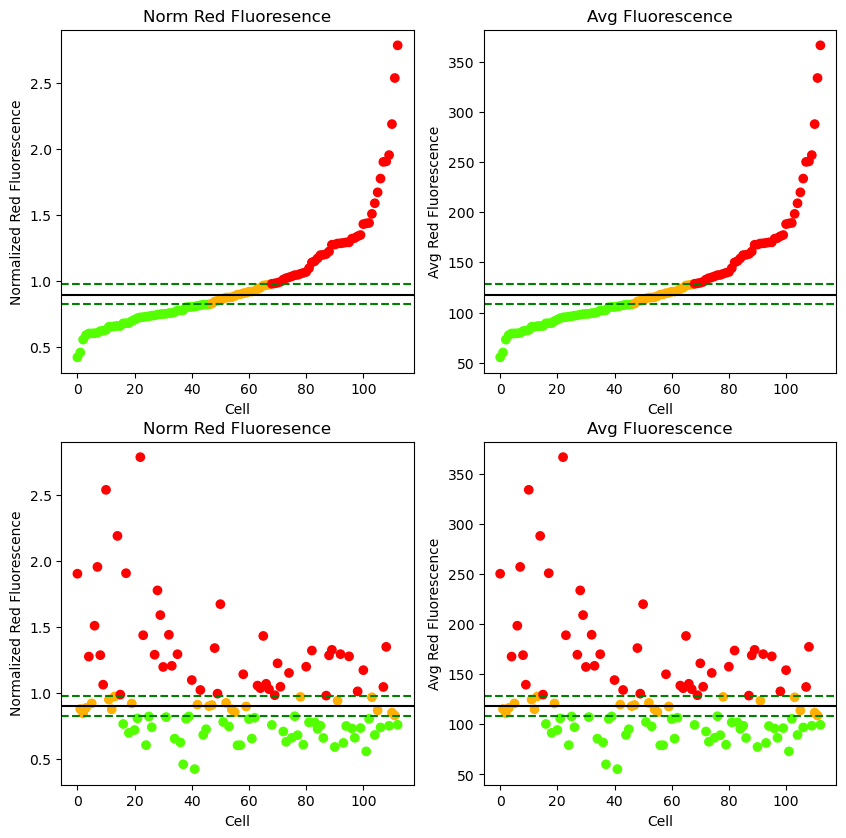

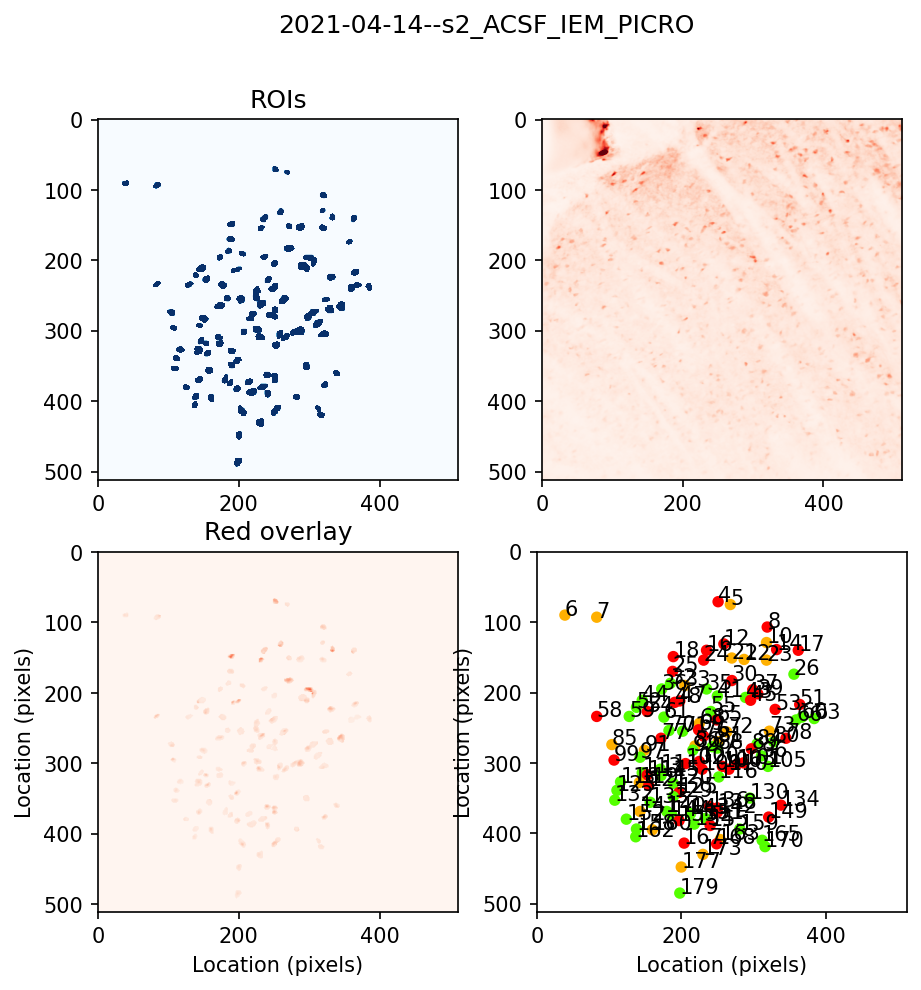

In [12]:
from Functions import _plot_fov
from Functions import _plot_id

_plot_id(frednorm, fredmean, d1_d2, cutoff, interval_pos, interval_neg, raw_cutoff, raw_interval_pos, raw_interval_neg, experiment, experiment_date)
_plot_fov(fchan, ops_orig, im, indices, experiment_date, experiment, xcoords, ycoords, d1_d2)

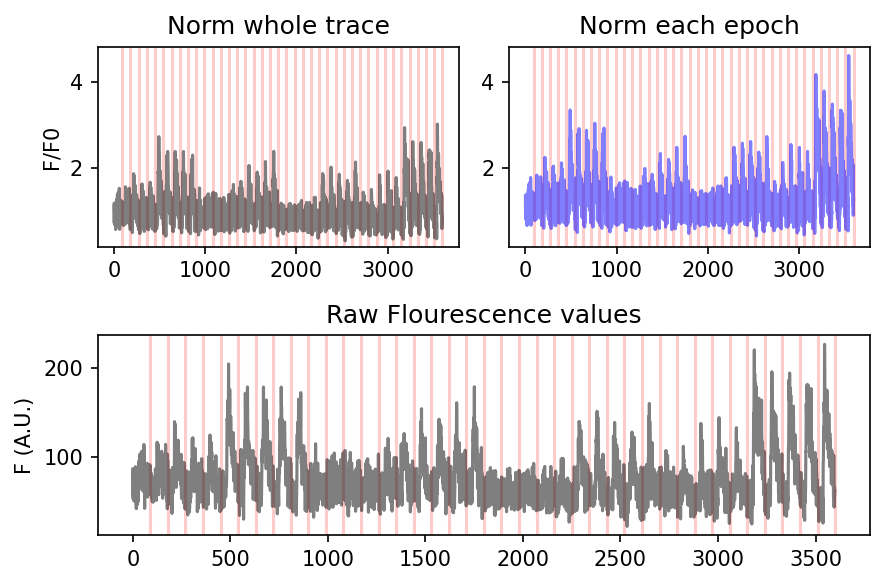

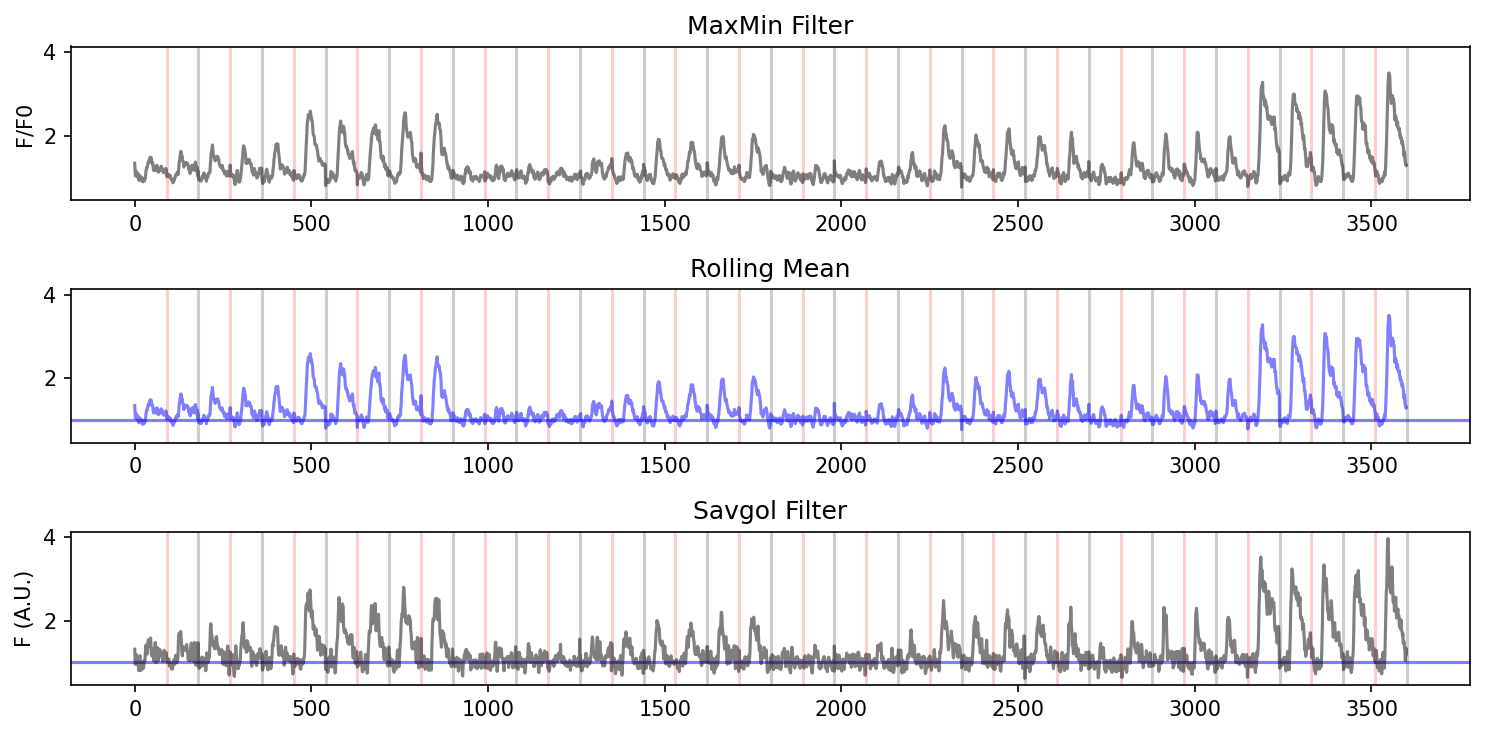

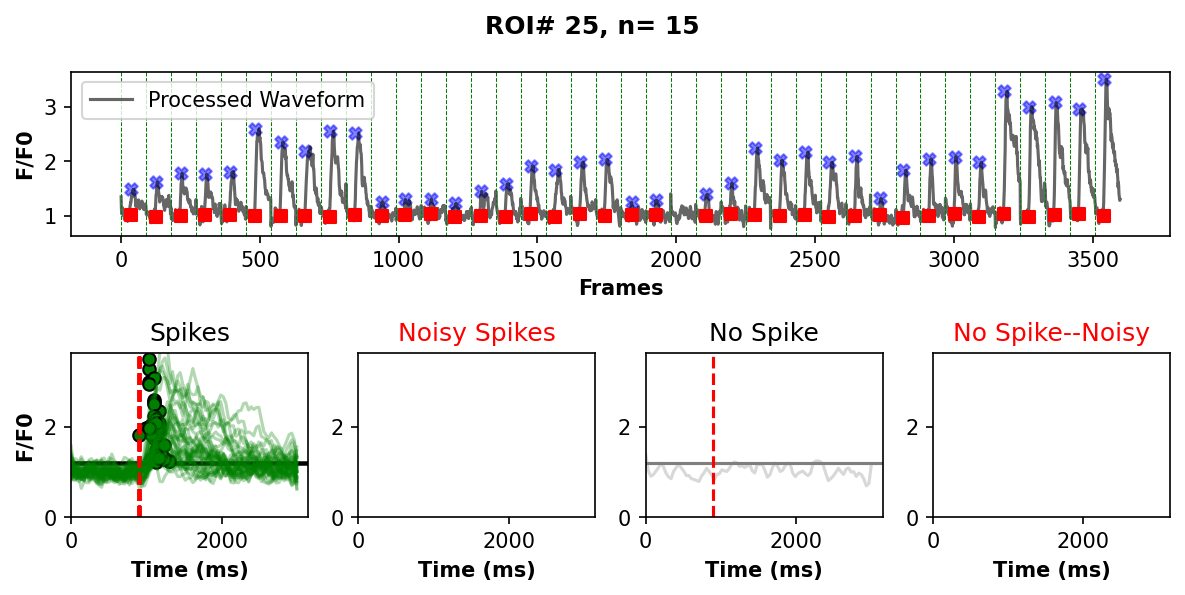

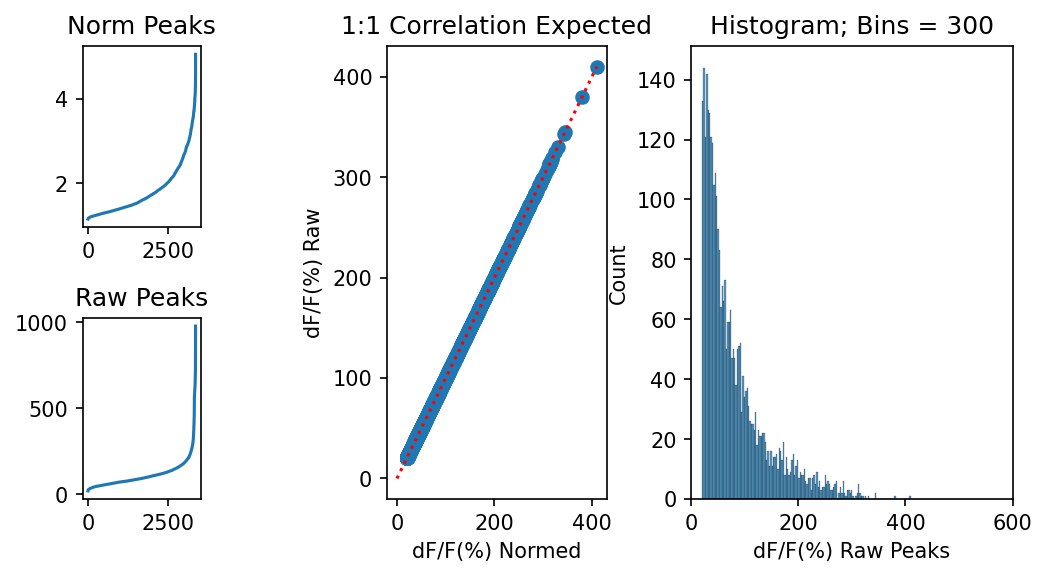

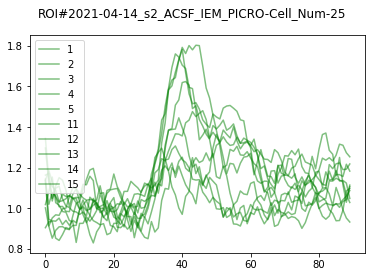

In [13]:
from Functions import _plot_normed_traces
from Functions import _plot_filtered_traces
from Functions import _plot_savgol_windows
from Functions import _plot_savgol_order
from Functions import _norm_raw_corr
from Functions import _plot_found_spikes       
from Functions import _wave_plot

#..........................................................................................................................................................

roi_num = 15
_plot_normed_traces(w_norm, e_norm_originalshape, d_cells, roi_num, framenum, stimulations, repetition, savefig=True) #...................................Plot normalized traces (whole trace norm and by_epoch norm)
# _plot_savgol_windows(e_norm, roi_num, framenum, d_cells.shape, stimulations, repetition, xmin = 1200, xlim = 1500) #....................................default order is 3. Windows are 7, 15, & 29. 
# _plot_savgol_order(e_norm, roi_num, framenum, d_cells.shape, stimulations, repetition, xmin = 1200, xlim = 1500) #......................................default window is 7. Order is 2 & 3. 
sp = roll_e.copy()
_plot_filtered_traces(sp, roll_e, sav_e, roi_num, framenum, d_cells.shape, stimulations, repetition, xmin=None, xlim=None) #..........................................compare suite2p min/max, rolling average, and Savgol filters. 


#..........................................................................................................................................................

cells_plotted = [i for i in range(15,16)]
_plot_found_spikes(roll_e, sav_e, d_cells, df, cells_plotted, spk_frame, Fmean_arr, Fpeak, #...............................................................Plots traces from specified ROIs with identified spikes. 
                   indices, stimulations, repetition, fs, stimtime, framenum, framerate,
                   rolling, 
                   savefig = False) 

#..........................................................................................................................................................
if rolling:
    title = "Rolling"
else: 
    title = "Savgol"
_norm_raw_corr(Fpeak, Fpeak2, dFoverF, dFoverF2, savefig=True, title=title) #.............................................................................Plot comparison of peak amplitudes from Raw and Normalized Values

#..........................................................................................................................................................

#................................For Chrimson Experiments. 
# prestim = [1,2,3,4,5]
# led = [6 + 4*i for i in range(5)]
# pre = [7 + 4*i for i in range(5)]
# post = [8 + 4*i for i in range(5)]
# stim = [9 + 4*i for i in range(5)]
# poststim = [26, 27, 28, 29, 30]
# check = [31]
#................................

first_roi = 15
last_roi = 16

stim = [1, 2, 3, 4, 5, 11, 12, 13, 14, 15]

_wave_plot(waves_df, stim, first_roi, last_roi) #..........................................................................................................Plots Waveform from specified ROIs ('first_roi', 'last_roi')